In [6]:
################################################################################
### Python port of rlasso.R
### https://github.com/cran/hdm/blob/master/R/rlasso.R
################################################################################

################################################################################
### 1: Load modules
################################################################################

# Standard Python modules
import joblib as jbl
import multiprocess as mp
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import LinearRegression as lm

# Other parts of hdmpy
from hdmpy.help_functions import cvec, init_values
from hdmpy.LassoShooting_fit import LassoShooting_fit

In [7]:
################################################################################
### 2: Define functions
################################################################################

################################################################################
### 2.1: Functions which are not in the original R package
###      These are generally helper functions to allow an implementation which
###      reads as closely to the original R code as possible, and to ease a
###      Python implementation, including parallelizing the code
################################################################################


# Define a function to simulate distributions needed for calculating X-dependent
# penalty terms
def simul_pen(n, p, W, seed=0, fix_seed=True):
    # Check whether the seed needs to be fixed
    if fix_seed:
        # Simulate with provided seed
        g = norm.rvs(size=(n,1), random_state=seed) @ np.ones(shape=(1,p))
    else:
        # Simulate using whatever state the RNG is currently in
        g = norm.rvs(size=(n,1)) @ np.ones(shape=(1,p))

    # Calculate element of the distribution for the current draw of g
    s = n * np.amax(2 * np.abs(np.mean(W * g, axis=0)))

    # Return the result
    return s

In [8]:
################################################################################
### 2.2: Functions which are in the original R package
################################################################################


def lambdaCalculation(homoskedastic=False, X_dependent_lambda=False,
                      lambda_start=None, c=1.1, gamma=0.1, numSim=5000, y=None,
                      x=None, par=True, corecap=np.inf, fix_seed=True):
    # Get number of observations n and number of variables p
    n, p = x.shape

    # Get number of simulations to use (if simulations are necessary)
    R = numSim

    # Go through all possible combinations of homoskedasticy/heteroskedasticity
    # and X-dependent or independent error terms. The first two cases are
    # special cases: Handling the case there homoskedastic was set to None, and
    # where lambda_start was provided.
    #
    # 1) If homoskedastic was set to None (special case)
    if homoskedastic is None:
        # Initialize lambda
        lmbda0 = lambda_start

        Ups0 = (1 / np.sqrt(n)) * np.sqrt((y**2).T @ (x**2)).T

        # Calculate the final vector of penalty terms
        lmbda = lmbda0 * Ups0

    # 2) If lambda_start was provided (special case)
    elif lambda_start is not None:
        # Check whether a homogeneous penalty term was provided (a scalar)
        if np.amax(cvec(lambda_start).shape) == 1:
            # If so, repeat that p times as the penalty term
            lmbda = np.ones(shape=(p,1)) * lambda_start
        else:
            # Otherwise, use the provided vector of penalty terms as is
            lmbda = lambda_start

    # 3) Homoskedastic and X-independent
    elif (homoskedastic == True) and (X_dependent_lambda == False):
        # Initilaize lambda
        lmbda0 = 2 * c * np.sqrt(n) * norm.ppf(1 - gamma/(2*p))

        # Use ddof=1 to be consistent with R's var() function
        Ups0 = np.sqrt(np.var(y, axis=0, ddof=1))

        # Calculate the final vector of penalty terms
        lmbda = np.zeros(shape=(p,1)) + lmbda0 * Ups0

    # 4) Homoskedastic and X-dependent
    elif (homoskedastic == True) and (X_dependent_lambda == True):
        psi = cvec((x**2).mean(axis=0))

        tXtpsi = (x.T / np.sqrt(psi)).T

        # Check whether to use parallel processing
        if par == True:
            # If so, get the number of cores to use
            cores = np.int(np.amin([mp.cpu_count(), corecap]))
        else:
            # Otherwise, use only one core (i.e. run sequentially)
            cores = 1

        # Get simulated distribution
        sim = jbl.Parallel(n_jobs=cores)(
            jbl.delayed(simul_pen)(
                n, p, tXtpsi, seed=l*20, fix_seed=fix_seed
            ) for l in np.arange(R)
        )

        # Convert it to a proper column vector
        sim = cvec(sim)

        # Initialize lambda based on the simulated quantiles
        lmbda0 = c * np.quantile(sim, q=1-gamma, axis=0)

        Ups0 = np.sqrt(np.var(y, axis=0, ddof=1))

        # Calculate the final vector of penalty terms
        lmbda = np.zeros(shape=(p,1)) + lmbda0 * Ups0

    # 5) Heteroskedastic and X-independent
    elif (homoskedastic == False) and (X_dependent_lambda == False):
        # The original includes the comment, "1=num endogenous variables"
        lmbda0 = 2 * c * np.sqrt(n) * norm.ppf(1 - gamma/(2*p*1))

        Ups0 = (1 / np.sqrt(n)) * np.sqrt((y**2).T @ (x**2)).T

        lmbda = lmbda0 * Ups0

    # 6) Heteroskedastic and X-dependent
    elif (homoskedastic == False) and (X_dependent_lambda == True):
        eh = y

        ehat = eh @ np.ones(shape=(1,p))

        xehat = x * ehat

        psi = cvec((xehat**2).mean(axis=0)).T

        tXehattpsi = (xehat / ( np.ones(shape=(n,1)) @ np.sqrt(psi) ))

        # Check whether to use parallel processing
        if par == True:
            # If so, get the number of cores to use
            cores = np.int(np.amin([mp.cpu_count(), corecap]))
        else:
            # Otherwise, use only one core (i.e. run sequentially)
            cores = 1

        # Get simulated distribution
        sim = jbl.Parallel(n_jobs=cores)(
            jbl.delayed(simul_pen)(
                n, p, tXehattpsi, seed=l*20, fix_seed=fix_seed
            ) for l in np.arange(R)
        )

        # Convert it to a proper column vector
        sim = cvec(sim)

        # Initialize lambda based on the simulated quantiles
        lmbda0 = c * np.quantile(sim, q=1-gamma, axis=0)

        Ups0 = (1 / np.sqrt(n)) * np.sqrt((y**2).T @ (x**2)).T

        # Calculate the final vector of penalty terms
        lmbda = lmbda0 * Ups0

    # Return results
    return {'lambda0': lmbda0, 'lambda': lmbda, 'Ups0': Ups0}

In [4]:
import hdmpy
import pandas as pd
import numpy as np
import pyreadr
import math
import matplotlib.pyplot as plt
import random

# I downloaded the data that the author used
growth_read = pyreadr.read_r("../../data/GrowthData.RData")

# Extracting the data frame from rdata_read
growth = growth_read[ 'GrowthData' ]


# We create the main variables
y = growth['Outcome']
X = growth.drop('Outcome', 1)

# Create main variables
Y = growth['Outcome']
W = growth.drop(['Outcome','intercept', 'gdpsh465'], 1 )
D = growth['gdpsh465']

C:\Users\ALEXAN~1\AppData\Local\Temp/ipykernel_32448/894338932.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = growth.drop('Outcome', 1)
C:\Users\ALEXAN~1\AppData\Local\Temp/ipykernel_32448/894338932.py:22: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  W = growth.drop(['Outcome','intercept', 'gdpsh465'], 1 )


,bmp1l,freeop,freetar,h65,hm65,hf65,p65,pm65,pf65,s65,...,seccf65,syr65,syrm65,syrf65,teapri65,teasec65,ex1,im1,xr65,tot1
0,0.2837,0.153491,0.043888,0.007,0.013,0.001,0.29,0.37,0.21,0.04,...,0.04,0.033,0.057,0.010,47.6,17.3,0.0729,0.0667,0.348,-0.014727
1,0.6141,0.313509,0.061827,0.019,0.032,0.007,0.91,1.00,0.65,0.16,...,0.64,0.173,0.274,0.067,57.1,18.0,0.0940,0.1438,0.525,0.005750
2,0.0000,0.204244,0.009186,0.260,0.325,0.201,1.00,1.00,1.00,0.56,...,18.14,2.573,2.478,2.667,26.5,20.7,0.1741,0.1750,1.082,-0.010040
3,0.1997,0.248714,0.036270,0.061,0.070,0.051,1.00,1.00,1.00,0.24,...,2.63,0.438,0.453,0.424,27.8,22.7,0.1265,0.1496,6.625,-0.002195
4,0.1740,0.299252,0.037367,0.017,0.027,0.007,0.82,0.85,0.81,0.17,...,2.11,0.257,0.287,0.229,34.5,17.6,0.1211,0.1308,2.500,0.003283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.0000,0.371898,0.014586,0.255,0.336,0.170,0.98,0.99,1.00,0.88,...,11.41,2.226,2.494,1.971,27.5,15.9,0.4407,0.4257,2.529,-0.011883
86,0.0050,0.296437,0.013615,0.108,0.117,0.093,1.00,1.00,0.96,0.53,...,1.95,0.510,0.694,0.362,20.2,15.7,0.1669,0.2201,25.553,-0.039080
87,0.0000,0.265778,0.008629,0.288,0.337,0.237,1.00,1.00,0.95,0.78,...,25.64,2.727,2.664,2.788,20.4,9.4,0.3238,0.3134,4.152,0.005175
88,0.0000,0.282939,0.005048,0.188,0.236,0.139,1.00,1.00,1.00,0.83,...,10.76,1.888,1.920,1.860,20.0,16.0,0.1845,0.1940,0.452,-0.029551


In [ ]:
import numpy as np
import random
import statsmodels.api as sm
# Set Seed
random.seed(10)
print(random.random())

n = 10
p = n//2
x = np.random.normal(0, 1, size=(n, p))
y = np.random.normal(0, 1,n)
beta = np.random.normal(0, 1,n)
lmbda = np.random.normal(0, 1,n)
gamma = 0.1

In [2]:
eh = y

ehat = eh @ np.ones(shape=(1,p))

xehat = x * ehat
psi = cvec((x**2).mean(axis=0)).T

NameError: name 'y' is not defined

In [3]:
a = x**2
a.shape
a

NameError: name 'x' is not defined

In [4]:
psi = cvec((x**2).mean(axis=0)).T
psi

NameError: name 'cvec' is not defined

In [5]:
y.T@np.ones(shape=(1,p))

NameError: name 'y' is not defined

In [6]:
np.ones(shape=(1,p)).shape

NameError: name 'np' is not defined

In [7]:
eh = y

ehat = eh @ np.ones(shape=(1,p))


NameError: name 'y' is not defined

In [8]:
Ups0 = (1 / np.sqrt(n)) * np.sqrt((y**2).T @ (x**2)).T
Ups0 

NameError: name 'np' is not defined

In [9]:
(y**2).T

NameError: name 'y' is not defined

In [10]:
(x**2)

NameError: name 'x' is not defined

In [16]:
(y**2).T@ (x**2)

array([10.50698976, 10.54606509,  4.6755079 ,  3.13173604,  5.64740867])

In [17]:
Ups0 = np.sqrt(np.var(y, axis=0, ddof=1))
Ups0

0.7711517720810301

In [18]:
norm.ppf(1 - gamma/(2*p))

2.3263478740408408

In [19]:
from scipy.stats import norm
import matplotlib.pyplot as plt

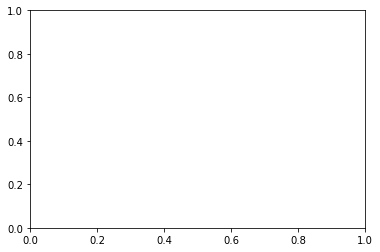

In [20]:
fig, ax = plt.subplots(1, 1)
mean, var, skew, kurt = norm.stats(moments='mvsk')

In [21]:
rv = norm()
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

In [22]:
norm.ppf(0.95, loc=0, scale=1)

1.6448536269514722

In [23]:
Ups0 = (1 / np.sqrt(n)) * np.sqrt((y**2).T @ (x**2)).T
Ups0

array([1.02503609, 1.02694036, 0.68377686, 0.55961916, 0.75149243])

In [24]:
class MyClass(object):

    def __init__(self, foo, bar):
        self.foo = foo
        self.bar = bar

    def do_something(self):
        return self.foo + self.bar

    def do_something_else(self, num):
        return num * self.bar


my_class = MyClass(1, 10)
my_class.do_something()  # returns 11
my_class.do_something_else(10)  # returns 100


100

In [25]:
import numpy as np 
colnames = ['V' + str(i+1) for i in np.arange(5)]
colnames

['V1', 'V2', 'V3', 'V4', 'V5']

In [47]:
meanx = x.mean(axis=0)
meanx = meanx.reshape(1,5)
meanx


array([[ 0.28392915,  0.10252166,  0.20850023, -0.08044977, -0.02219457]])

In [44]:
meanx.shape

(1, 5)

In [48]:
np.ones(shape=(n,1))

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [ ]:
np.ones(shape=(n,1)) @ meanx

In [26]:
################################################################################
### 3: Define classes
################################################################################

class rlasso:
    # Initialize gamma to None to get gamma=.1/log(n)
    def __init__(self, x, y, colnames=None, post=True, intercept=True,
                 model=True, homoskedastic=False, X_dependent_lambda=False,
                 lambda_start=None, c=1.1, gamma=None, numSim=5000, numIter=15,
                 tol=10**(-5), threshold=-np.inf, par=True, corecap=np.inf,
                 fix_seed=True):
        # Initialize internal variables
        if isinstance(x, pd.DataFrame) and colnames is None:
            colnames = x.columns

        self.x = np.array(x).astype(np.float32)
        self.y = cvec(y).astype(np.float32)

        self.n, self.p = self.x.shape

        if colnames is None:
            self.colnames = ['V' + str(i+1) for i in np.arange(self.p)]
        else:
            self.colnames = colnames

        # Unused line in the original code
        # ind_names = np.arange(self.p) + 1

        self.post = post
        self.intercept = intercept
        self.model = model
        self.homoskedastic = homoskedastic
        self.X_dependent_lambda = X_dependent_lambda
        self.lambda_start = lambda_start
        self.c = c

        if gamma is None:
            self.gamma = .1 / np.log(self.n)
        else:
            self.gamma = gamma

        self.numSim = numSim
        self.numIter = numIter
        self.tol = tol
        self.threshold = threshold

        self.par = par
        self.corecap = corecap
        self.fix_seed = fix_seed

        if (self.post == False) and (self.c is None):
            self.c = .5

        if (
                (self.post == False) and (self.homoskedastic == False)
                and (self.X_dependent_lambda == False)
                and (self.lambda_start == None) and (self.c == 1.1)
                and (self.gamma == .1 / np.log(self.n))
        ):
            self.c = .5

        # For now, instantiate estimate as None
        self.est = None

        # Calculate robust LASSO coefficients
        if self.intercept == True:
            meanx = cvec(self.x.mean(axis=0))

            self.x = self.x - np.ones(shape=(self.n,1)) @ meanx.T

            mu = self.y.mean()

            self.y = self.y - mu
        else:
            meanx = np.zeros(shape=(self.p,1))

            mu = 0

        normx = np.sqrt(np.var(self.x, axis=1, ddof=1))

        Psi = cvec(np.mean(self.x**2, axis=0))

        ind = np.zeros(shape=(self.p,1)).astype(bool)

        XX = self.x.T @ self.x

        Xy = self.x.T @ self.y

        startingval = init_values(self.x, self.y)['residuals']

        pen = lambdaCalculation(homoskedastic=self.homoskedastic,
                                X_dependent_lambda=self.X_dependent_lambda,
                                lambda_start=self.lambda_start, c=self.c,
                                gamma=self.gamma, numSim=self.numSim,
                                y=startingval, x=self.x, par=self.par,
                                corecap=self.corecap, fix_seed=self.fix_seed)

        lmbda = pen['lambda']
        Ups0 = Ups1 = pen['Ups0']
        lmbda0 = pen['lambda0']

        mm = 1
        s0 = np.sqrt(np.var(y, axis=0, ddof=1))

        while mm <= self.numIter:
            if (mm == 1) and self.post:
                coefTemp = (
                    LassoShooting_fit(self.x, self.y, lmbda/2, XX=XX,
                                      Xy=Xy)['coefficients']
                )
            else:
                coefTemp = (
                    LassoShooting_fit(self.x, self.y, lmbda, XX=XX,
                                      Xy=Xy)['coefficients']
                )

            coefTemp[np.isnan(coefTemp)] = 0

            ind1 = (np.abs(coefTemp) > 0)

            x1 = self.x[:, ind1[:,0]]

            if x1.shape[1] == 0:
                if self.intercept:
                    intercept_value = np.mean(self.y + mu)

                    coef = np.zeros(shape=(self.p+1,1))

                    coef = (
                        pd.DataFrame(coef,
                                     index=['(Intercept)']+list(self.colnames))
                    )
                else:
                    intercept_value = np.mean(self.y)

                    coef = np.zeros(shape=(self.p,1))

                    coef = pd.DataFrame(coef, index=self.colnames)

                self.est = {
                    'coefficients': coef,
                    'beta': np.zeros(shape=(self.p,1)),
                    'intercept': intercept_value,
                    'index': pd.DataFrame(np.zeros(shape=(self.p,1)).astype(
                        bool),
                                          index=self.colnames),
                    'lambda': lmbda,
                    'lambda0': lmbda0,
                    'loadings': Ups0,
                    'residuals': self.y - np.mean(self.y),
                    'sigma': np.var(self.y, axis=0, ddof=1),
                    'iter': mm,
                    #'call': Not a Python option
                    'options': {'post': self.post, 'intercept': self.intercept,
                                'ind.scale': ind, 'mu': mu, 'meanx': meanx}
                }

                if self.model:
                    self.est['model'] = self.x
                else:
                    self.est['model'] = None

                self.est['tss'] = self.est['rss'] = (
                    ((self.y - np.mean(self.y))**2).sum()
                )

                self.est['dev']: self.y - np.mean(self.y)
                # In R, return() breaks while loops
                return

            # Refinement variance estimation
            if self.post:
                reg = lm(fit_intercept=False).fit(x1, self.y)

                coefT = reg.coef_.T

                coefT[np.isnan(coefT)] = 0

                e1 = self.y - x1 @ coefT

                coefTemp[ind1[:,0]] = coefT
            else:
                e1 = self.y - x1@ coefTemp[ind1[:,0]]

            s1 = np.sqrt(np.var(e1, ddof=1))

            # Homoskedastic and X-independent
            if (
                    (self.homoskedastic == True)
                    and (self.X_dependent_lambda == False)
            ):
                Ups1 = s1 * Psi

                lmbda = pen['lambda0'] * Ups1

            # Homoskedastic and X-dependent
            elif (
                    (self.homoskedastic == True)
                    and (self.X_dependent_lambda == True)
            ):
                Ups1 = s1 * Psi

                lmbda = pen['lambda0'] * Ups1

            # Heteroskedastic and X-independent
            elif (
                    (self.homoskedastic == False)
                    and (self.X_dependent_lambda == False)
            ):
                Ups1 = (
                    (1/np.sqrt(self.n)) * np.sqrt((e1**2).T @ self.x**2).T
                )

                lmbda = pen['lambda0'] * Ups1

            # Heteroskedastic and X-dependent
            elif (
                    (self.homoskedastic == False)
                    and (self.X_dependent_lambda == True)
            ):
                lc = lambdaCalculation(homoskedastic=self.homoskedastic,
                                       X_dependent_lambda=
                                       self.X_dependent_lambda,
                                       lambda_start=self.lambda_start,
                                       c=self.c, gamma=self.gamma,
                                       numSim=self.numSim, y=e1, x=self.x,
                                       par=self.par, corecap=self.corecap,
                                       fix_seed=self.fix_seed)

                Ups1 = lc['Ups0']

                lmbda = lc['lambda']

            # If homoskedastic is set to None
            elif self.homoskedastic is None:
                Ups1 = (
                    (1/np.sqrt(self.n)) * np.sqrt((e1**2).T @ self.x**2).T
                )

                lmbda = pen['lambda0'] * Ups1

            mm = mm + 1

            if np.abs(s0 - s1) < self.tol:
                break

            s0 = s1

        if x1.shape[1] == 0:
            #coefTemp = None
            ind1 = np.zeros(shape=(self.p,1))

        coefTemp = cvec(coefTemp)

        coefTemp[np.abs(coefTemp) < self.threshold] = 0

        coefTemp = pd.DataFrame(coefTemp, index=self.colnames)

        ind1 = cvec(ind1)

        ind1 = pd.DataFrame(ind1, index=self.colnames)

        if self.intercept:
            if mu is None:
                mu = 0
            if meanx is None:
                meanx = np.zeros(shape=(coefTemp.shape[0],1))
            if ind.sum() == 0:
                intercept_value = mu - (meanx * coefTemp).sum()
            else:
                intercept_value = mu - (meanx * coefTemp).sum()
        else:
            intercept_value = np.nan

        if self.intercept:
            beta = (
                np.concatenate([cvec(intercept_value), coefTemp.values], axis=0)
            )

            beta = pd.DataFrame(beta, index=['(Intercept)']+list(self.colnames))
        else:
            beta = coefTemp

        s1 = np.sqrt(np.var(e1, ddof=1))

        self.est = {
            'coefficients': beta,
            'beta': pd.DataFrame(coefTemp, index=self.colnames),
            'intercept': intercept_value,
            'index': ind1,
            'lambda': pd.DataFrame(lmbda, index=self.colnames),
            'lambda0': lmbda0,
            'loadings': Ups1,
            'residuals': cvec(e1),
            'sigma': s1,
            'iter': mm,
            #'call': Not a Python option
            'options': {'post': self.post, 'intercept': self.intercept,
                        'ind.scale': ind, 'mu': mu, 'meanx': meanx},
            'model': model
        }

        if model:
            self.x = self.x + np.ones(shape=(self.n,1)) @ meanx.T

            self.est['model'] = self.x
        else:
            self.est['model'] = None

        self.est['tss'] = ((self.y - np.mean(self.y))**2).sum()
        self.est['rss'] = (self.est['residuals']**2).sum()
        self.est['dev'] = self.y - np.mean(self.y)